# Reduce maintenance cost through predictive techniques 

## Background 
Company (3D Technologies) has a fleet of devices transmitting daily aggregated telemetry
attributes. 
Predictive maintenance techniques are designed to help determine the condition of in-service
equipment in order to predict when maintenance should be performed. This approach
promises cost savings over routine or time-based preventive maintenance, because tasks are
performed only when warranted. 


## Goal 
You are tasked with building a predictive model using machine learning to predict the
probability of a device failure. When building this model, be sure to minimize false positives and
false negatives. The column you are trying to predict is called failure with binary value 0 for
non-failure and 1 for failure

## Data
the data used can be downloaded on the following link.


link: http://aws-proserve-data-science.s3.amazonaws.com/device_failure.csv 

## Import Packages

In [68]:
import pandas as pd
import numpy as np 
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import XGBClassifier
from functions.main_functions import plot_curve_roc
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data and specify encoding
df = pd.read_csv('device_failure.csv', encoding='ISO-8859-1')

In [3]:
# Inspect the data
print(df.shape)
df.head()

(124494, 12)


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [4]:
df['device'].value_counts()

S1F0GGPP    304
Z1F0GE1M    304
S1F0EGMT    304
W1F05X69    304
W1F0G9T7    304
           ... 
S1F0LEBM      5
Z1F14Z4F      5
S1F04KSC      4
W1F0WJFT      3
W1F1DA5ÿ      1
Name: device, Length: 1169, dtype: int64

In [5]:
print('Number of unique devices:', len(df.device.unique()))

Number of unique devices: 1169


<font size="3">Out of all the data readings we only have `1169` devices

In [6]:
df.nunique()

date             304
device          1169
failure            2
attribute1    123877
attribute2       558
attribute3        47
attribute4       115
attribute5        60
attribute6     44838
attribute7        28
attribute8        28
attribute9        65
dtype: int64

In [7]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [8]:
df['failure'].value_counts()

0    124388
1       106
Name: failure, dtype: int64

<font size="3">The predictor variable `"failure"` has two binary values
* `Failure` with binary value 1 
*`Non-failure` with binary value 0

The Total number of failure:106
The Total number of Non-failure:124388

In [9]:
df['date'].head()

0    2015-01-01
1    2015-01-01
2    2015-01-01
3    2015-01-01
4    2015-01-01
Name: date, dtype: object

In [10]:
df['date'].tail()

124489    2015-11-02
124490    2015-11-02
124491    2015-11-02
124492    2015-11-02
124493    2015-11-02
Name: date, dtype: object

In [11]:
print('Start date:\t\t',min(df['date']))
print('End / latest date:\t',max(df['date']))

Start date:		 2015-01-01
End / latest date:	 2015-11-02


<font size="3"> The device sensors started recording data on `2015-01-01`, and the latest date was on `2015-11-02`


# EDA

In [12]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
failure,124494.0,8.514467e-04,2.916725e-02,0.0,0.0,0.0,0.0,1.0
attribute1,124494.0,1.223881e+08,7.045933e+07,0.0,61284762.0,122797388.0,183309640.0,244140480.0
attribute2,124494.0,1.594848e+02,2.179658e+03,0.0,0.0,0.0,0.0,64968.0
attribute3,124494.0,9.940455e+00,1.857473e+02,0.0,0.0,0.0,0.0,24929.0
attribute4,124494.0,1.741120e+00,2.290851e+01,0.0,0.0,0.0,0.0,1666.0
attribute5,124494.0,1.422267e+01,1.594303e+01,1.0,8.0,10.0,12.0,98.0
attribute6,124494.0,2.601727e+05,9.915108e+04,8.0,221452.0,249799.5,310266.0,689161.0
attribute7,124494.0,2.925282e-01,7.436924e+00,0.0,0.0,0.0,0.0,832.0
attribute8,124494.0,2.925282e-01,7.436924e+00,0.0,0.0,0.0,0.0,832.0
attribute9,124494.0,1.245152e+01,1.914256e+02,0.0,0.0,0.0,0.0,18701.0


In [18]:
df.columns.to_list()

['date',
 'device',
 'failure',
 'attribute1',
 'attribute2',
 'attribute3',
 'attribute4',
 'attribute5',
 'attribute6',
 'attribute7',
 'attribute8',
 'attribute9']

In [17]:
df1 = pd.melt(df, id_vars=['date', 'device','failure'], 
              value_vars=['attribute1','attribute2','attribute3',
                            'attribute4','attribute5','attribute6',
                            'attribute7','attribute8','attribute9'])

In [18]:
df1

,date,device,failure,variable,value
0,2015-01-01,S1F01085,0,attribute1,215630672
1,2015-01-01,S1F0166B,0,attribute1,61370680
2,2015-01-01,S1F01E6Y,0,attribute1,173295968
3,2015-01-01,S1F01JE0,0,attribute1,79694024
4,2015-01-01,S1F01R2B,0,attribute1,135970480
...,...,...,...,...,...
1120441,2015-11-02,Z1F0MA1S,0,attribute9,0
1120442,2015-11-02,Z1F0Q8RT,0,attribute9,13
1120443,2015-11-02,Z1F0QK05,0,attribute9,0
1120444,2015-11-02,Z1F0QL3N,0,attribute9,0


### Investigate Outliers

<AxesSubplot:xlabel='variable', ylabel='value'>

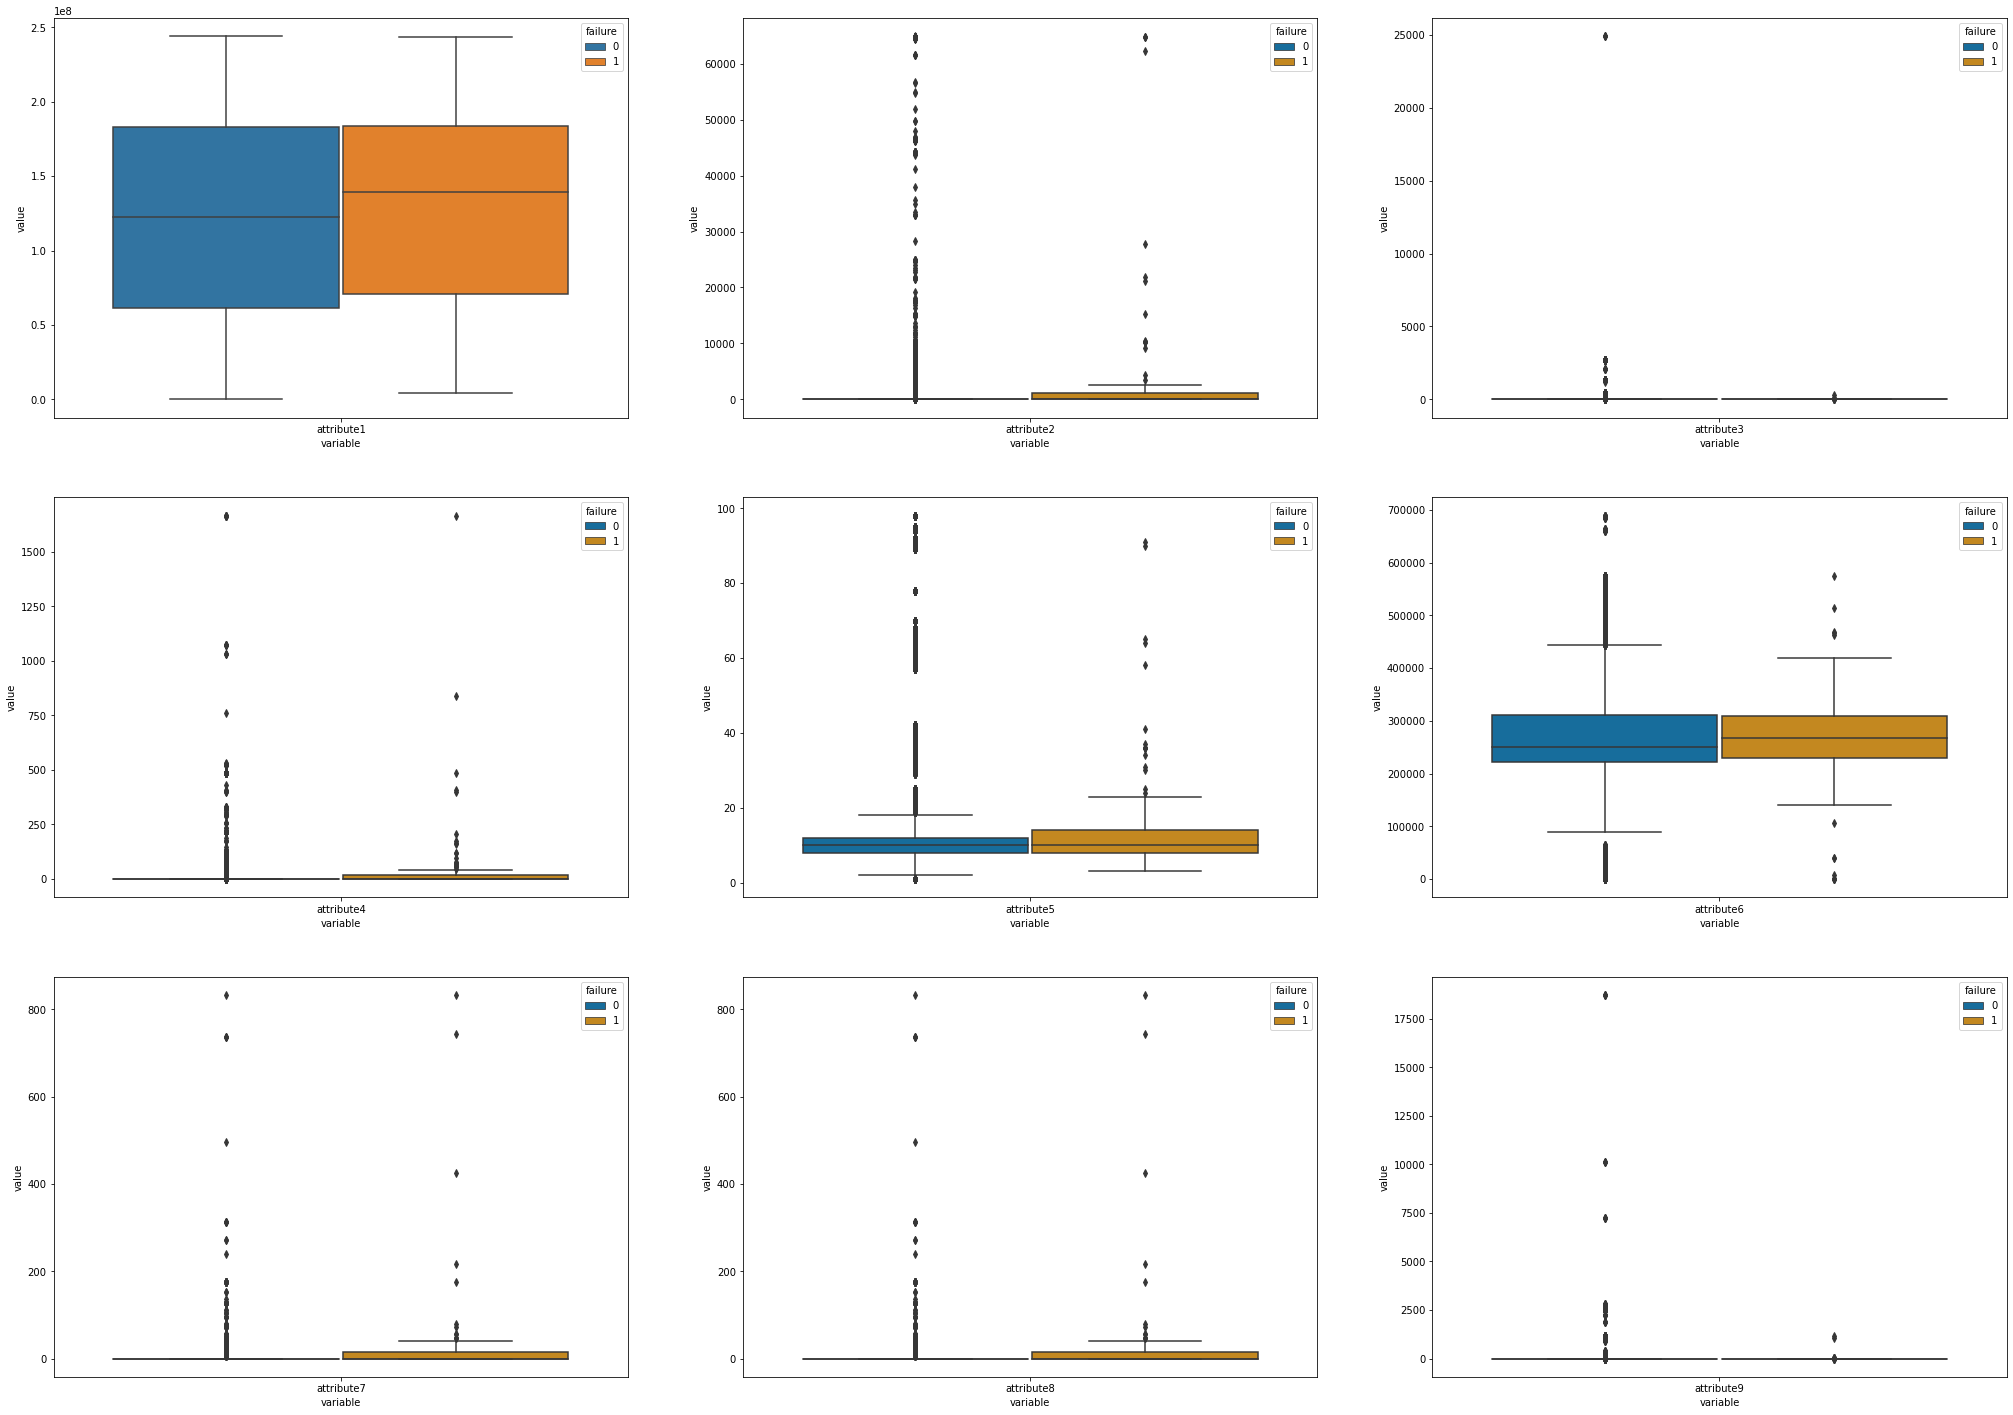

In [19]:
fig = plt.figure(figsize=(35, 25))
ax1 =fig.add_subplot(3,3,1)
sns.boxplot(x = 'variable', y = 'value',
                 data=df1[df1['variable'].isin(['attribute1'])], hue = 'failure')

ax2 =fig.add_subplot(3,3,2)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df1[df1['variable'].isin(['attribute2'])], hue = 'failure',
                 palette="colorblind")

ax3 =fig.add_subplot(3,3,3)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df1[df1['variable'].isin(['attribute3'])], hue = 'failure',
                 palette="colorblind")

ax4 =fig.add_subplot(3,3,4)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df1[df1['variable'].isin(['attribute4'])], hue = 'failure',
                 palette="colorblind")

ax5 =fig.add_subplot(3,3,5)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df1[df1['variable'].isin(['attribute5'])], hue = 'failure',
                 palette="colorblind")

ax6 =fig.add_subplot(3,3,6)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df1[df1['variable'].isin(['attribute6'])], hue = 'failure',
                 palette="colorblind")

ax7 =fig.add_subplot(3,3,7)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df1[df1['variable'].isin(['attribute7'])], hue = 'failure',
                 palette="colorblind")

ax8 =fig.add_subplot(3,3,8)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df1[df1['variable'].isin(['attribute8'])], hue = 'failure',
                 palette="colorblind")

ax9 =fig.add_subplot(3,3,9)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df1[df1['variable'].isin(['attribute9'])], hue = 'failure',
                 palette="colorblind")


<font size="3">From the Plots above it's clear that attribute1 has no outliers in both failure and non-failure classes, whereas the following attributes from attribute2 to attribute9 has extreme outliers as it is also shown from the summary statistic that the mean is a bit higher than the median and the distance between the 75th percentile and Max is extreme

<AxesSubplot:title={'center':'Failure'}>

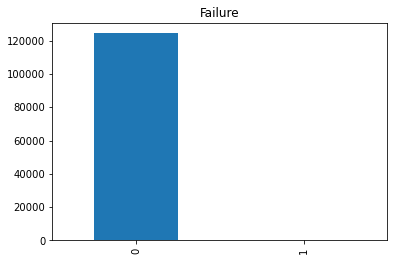

In [24]:
df['failure'].value_counts().plot(kind='bar', title = 'Failure')

### Probabbility of a class being correctly predicted

In [20]:
print('failure    :\t',round(len(df[df['failure'] ==1])/len(df)*100, 3),'%')
print('non-failure:\t',round(len(df[df['failure'] == 0])/len(df)*100, 3),'%')

failure    :	 0.085 %
non-failure:	 99.915 %


<font size="3">A model would mostly predict `non-failure` . our model would predict the class correctly approximatley 99.9% of the time this is due because of the class imbalance. To assess the models we fit, I will compare them to this baseline. I will later use SNOTE to balance the data

## Pre-Processing


We will start by pre-processing the data so that we can run it through the model. 

This involves:

- Splitting the data into features and labels;
- Standardise the data using `sklearn`'s `StandardScaler`;
- Splitting the data into training and testing data.

### Feature Scaling

In [26]:
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

## Model Training and Assessing

In [21]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [22]:
# Predictor Variavbles
X = df.drop(['failure','device','date'], axis = 1).values

# Response Variables
y = df['failure']

In [23]:
print('Predictor Variavbles \n',X,'\n\nResponse Variables\n',
      y[0:5])

Predictor Variavbles 
 [[215630672        56         0 ...         0         0         7]
 [ 61370680         0         3 ...         0         0         0]
 [173295968         0         0 ...         0         0         0]
 ...
 [ 19029120      4832         0 ...         0         0         0]
 [226953408         0         0 ...         0         0         0]
 [ 17572840         0         0 ...         0         0         0]] 

Response Variables
 0    0
1    0
2    0
3    0
4    0
Name: failure, dtype: int64


In [24]:
# Status Details - Target variable
#-1 = failure,
#-0 = non-failure, 

df.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

### Splitting the dataset into the Training set and Test set

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

## Decision Tree Classifier
Decision trees, which are the foundation of all tree-based models.

### Training


In [30]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Testing


In [31]:
y_pred = dt_classifier.predict(X_test)

In [32]:
## counting values in each class we have in this testset 
y_test.value_counts()

0    37319
1       30
Name: failure, dtype: int64

In [33]:
classes = ['non-failure', 'failure']

pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=classes, columns=classes)

,non-failure,failure
non-failure,37295,24
failure,27,3


The model can classify most of the classes correcly... I'll also take a look at the classification report for the predicted values the check the accuracy score.

In [36]:
print(classification_report(y_test, y_pred, target_names = ['non-failure', 'failure']))

              precision    recall  f1-score   support

 non-failure       1.00      1.00      1.00     37319
     failure       0.11      0.10      0.11        30

    accuracy                           1.00     37349
   macro avg       0.56      0.55      0.55     37349
weighted avg       1.00      1.00      1.00     37349



In [37]:
accuracy_score(y_test, y_pred)

0.9986345015930814

Overfitting turns out to be a general property of decision tree, however it can be avoided by using
- **Pre-pruning** that stop growing the tree earlier, before it perfectly classifies the training set.
- **Post-pruning** that allows the tree to perfectly classify the training set, and then post prune the tree. 

We will explore the above later

 [avoiding overfitting - Decision Tree](https://www.saedsayad.com/decision_tree_overfitting.htm#:~:text=increased%20test%20set%20error.,then%20post%20prune%20the%20tree)

## Random Forest
Random forest, is an “**ensemble**” method which builds many decision trees in parallel.

They can be trained quickly. Since trees do not rely on one another, they can be trained in parallel.

### Training




In [38]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing

In [39]:
## counting values in each class we have in this testset 
y_test.value_counts()

0    37319
1       30
Name: failure, dtype: int64

In [40]:
# predict classes
y_pred = rf_classifier.predict(X_test)

In [41]:
classes = ['non-failure', 'failure']

pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=classes, columns=classes)

,non-failure,failure
non-failure,37314,5
failure,30,0


In [42]:
print(classification_report(y_test, y_pred, target_names = ['non-failure', 'failure']))

              precision    recall  f1-score   support

 non-failure       1.00      1.00      1.00     37319
     failure       0.00      0.00      0.00        30

    accuracy                           1.00     37349
   macro avg       0.50      0.50      0.50     37349
weighted avg       1.00      1.00      1.00     37349



## Gradient Boost
Gradient boosting, is an “**ensemble**” method which builds many decision trees sequentially.
They are good at dealing with imbalanced data, but slower to train, since trees must be built sequentially 


### Training




In [46]:
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

### Testing




In [47]:
## counting values in each class we have in this testset 
y_test.value_counts()

0    37319
1       30
Name: failure, dtype: int64

In [48]:
# predict classes
y_pred = gb_classifier.predict(X_test)

In [49]:
classes = ['non-failure', 'failure']

pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=classes, columns=classes)

,non-failure,failure
non-failure,37308,11
failure,27,3


In [50]:
print(classification_report(y_test, y_pred, target_names = ['non-failure', 'failure']))

              precision    recall  f1-score   support

 non-failure       1.00      1.00      1.00     37319
     failure       0.21      0.10      0.14        30

    accuracy                           1.00     37349
   macro avg       0.61      0.55      0.57     37349
weighted avg       1.00      1.00      1.00     37349



### KNeighbors Classifier

### Training




In [51]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Testing

In [52]:
# predict classes
y_pred = knn.predict(X_test)

In [53]:
classes = ['non-failure', 'failure']

pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=classes, columns=classes)

,non-failure,failure
non-failure,37319,0
failure,30,0


In [55]:
print(classification_report(y_test, y_pred, target_names = ['non-failure', 'failure']))

              precision    recall  f1-score   support

 non-failure       1.00      1.00      1.00     37319
     failure       0.00      0.00      0.00        30

    accuracy                           1.00     37349
   macro avg       0.50      0.50      0.50     37349
weighted avg       1.00      1.00      1.00     37349



### XGBoost model


### Training

In [56]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)

[21:44:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Testing

In [57]:
# predict classes
y_pred = xgb.predict(X_test)

In [58]:
classes = ['non-failure', 'failure']

pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=classes, columns=classes)

,non-failure,failure
non-failure,37314,5
failure,30,0


In [59]:
print(classification_report(y_test, y_pred, target_names = ['non-failure', 'failure']))

              precision    recall  f1-score   support

 non-failure       1.00      1.00      1.00     37319
     failure       0.00      0.00      0.00        30

    accuracy                           1.00     37349
   macro avg       0.50      0.50      0.50     37349
weighted avg       1.00      1.00      1.00     37349



From all the above trained models we can see that they cannot predict failure because they are suffering from DATA IMBALANCE and that results in the model being biased to the majority class

## Data Balance

In [60]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)
X_trainos, y_trainos = oversample.fit_resample(X_train, y_train)

## Decision Tree Classifier


### Training


In [61]:

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_trainos, y_trainos)

DecisionTreeClassifier(random_state=42)

### Testing


In [62]:
y_pred = dt_classifier.predict(X_test)


In [63]:
## counting values in each class we have in this testset 
y_test.value_counts()

0    37319
1       30
Name: failure, dtype: int64

In [64]:
classes = ['non-failure', 'failure']
pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=classes, columns=classes)

,non-failure,failure
non-failure,37191,128
failure,26,4


In [65]:
print(classification_report(y_test, y_pred, target_names = ['non-failure', 'failure']))

              precision    recall  f1-score   support

 non-failure       1.00      1.00      1.00     37319
     failure       0.03      0.13      0.05        30

    accuracy                           1.00     37349
   macro avg       0.51      0.56      0.52     37349
weighted avg       1.00      1.00      1.00     37349



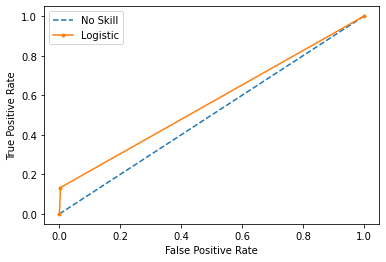

AUC: 0.565


In [69]:
plot_curve_roc(dt_classifier,X_test,y_test)
print("AUC: %.3f" % (roc_auc_score(y_test, y_pred)))

## Random Forest
Random forest, is an “**ensemble**” method which builds many decision trees in parallel.

They can be trained quickly. Since trees do not rely on one another, they can be trained in parallel.

### Training

In [70]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_trainos, y_trainos)

RandomForestClassifier(random_state=42)

### Testing



In [71]:
## counting values in each class we have in this testset 
y_test.value_counts()

0    37319
1       30
Name: failure, dtype: int64

In [72]:
# predict classes
y_pred = rf_classifier.predict(X_test)

In [73]:
classes = ['non-failure', 'failure']

pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=classes, columns=classes)

,non-failure,failure
non-failure,37234,85
failure,24,6


In [74]:
print(classification_report(y_test, y_pred, target_names = ['non-failure', 'failure']))

              precision    recall  f1-score   support

 non-failure       1.00      1.00      1.00     37319
     failure       0.07      0.20      0.10        30

    accuracy                           1.00     37349
   macro avg       0.53      0.60      0.55     37349
weighted avg       1.00      1.00      1.00     37349



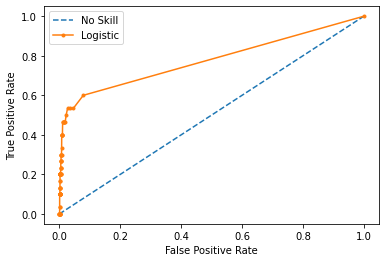

AUC: 0.599


In [75]:
plot_curve_roc(rf_classifier,X_test,y_test)
print("AUC: %.3f" % (roc_auc_score(y_test, y_pred)))



## Gradient Boost
Gradient boosting, is an “**ensemble**” method which builds many decision trees sequentially.
They are good at dealing with imbalanced data, but slower to train, since trees must be built sequentially 


### Training



In [76]:
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_trainos, y_trainos)

GradientBoostingClassifier(random_state=42)

### Testing



In [77]:
## counting values in each class we have in this testset 
y_test.value_counts()

0    37319
1       30
Name: failure, dtype: int64

In [78]:
# predict classes
y_pred = gb_classifier.predict(X_test)

In [79]:
classes = ['non-failure', 'failure']

pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=classes, columns=classes)

,non-failure,failure
non-failure,35734,1585
failure,11,19


In [80]:
print(classification_report(y_test, y_pred, target_names = ['non-failure', 'failure']))

              precision    recall  f1-score   support

 non-failure       1.00      0.96      0.98     37319
     failure       0.01      0.63      0.02        30

    accuracy                           0.96     37349
   macro avg       0.51      0.80      0.50     37349
weighted avg       1.00      0.96      0.98     37349



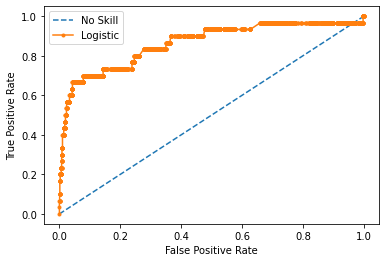

AUC: 0.795


In [81]:
plot_curve_roc(gb_classifier,X_test,y_test)
print("AUC: %.3f" % (roc_auc_score(y_test, y_pred)))



### KNeighbors Classifier

### Training





In [82]:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_trainos, y_trainos)

KNeighborsClassifier(n_neighbors=3)

### Testing


In [83]:
# predict classes
y_pred = knn.predict(X_test)

In [84]:
classes = ['non-failure', 'failure']

pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=classes, columns=classes)

,non-failure,failure
non-failure,30004,7315
failure,23,7


In [85]:
print(classification_report(y_test, y_pred, target_names = ['non-failure', 'failure']))

              precision    recall  f1-score   support

 non-failure       1.00      0.80      0.89     37319
     failure       0.00      0.23      0.00        30

    accuracy                           0.80     37349
   macro avg       0.50      0.52      0.45     37349
weighted avg       1.00      0.80      0.89     37349



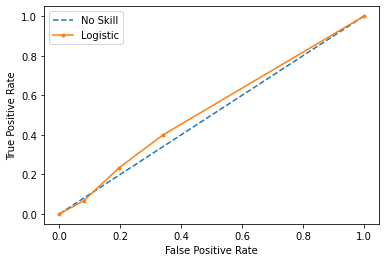

AUC: 0.519


In [86]:
plot_curve_roc(knn,X_test,y_test)
print("AUC: %.3f" % (roc_auc_score(y_test, y_pred)))


### XGBoost model


### Training



In [87]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_trainos, y_trainos)

[21:48:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Testing



In [88]:
# predict classes
y_pred = xgb.predict(X_test)

In [89]:
classes = ['non-failure', 'failure']

pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=classes, columns=classes)

,non-failure,failure
non-failure,37140,179
failure,24,6


In [90]:
print(classification_report(y_test, y_pred, target_names = ['non-failure', 'failure']))

              precision    recall  f1-score   support

 non-failure       1.00      1.00      1.00     37319
     failure       0.03      0.20      0.06        30

    accuracy                           0.99     37349
   macro avg       0.52      0.60      0.53     37349
weighted avg       1.00      0.99      1.00     37349



In [91]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

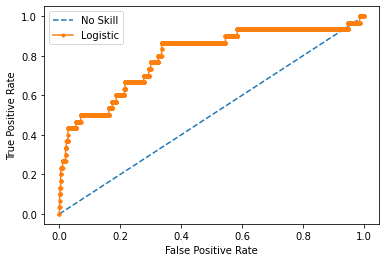

AUC: 0.598


In [92]:
plot_curve_roc(xgb,X_test,y_test)

print("AUC: %.3f" % (roc_auc_score(y_test, y_pred)))

# Feedback

<font size="3">I've inspected the data it has a huge imbalanced in response variable, to address that a SMOTE technique was adopted to do upsample and balance the data.
    
 I've also trained difference classification models and Gradient Boost had accuracy score of 96% after balancing of the data and I was able to compute a AUC score of 0.795 of which was the highest in all the models which was able to correctly classify 19/30 true positives for failure and 35734/37319 true positives non-failure. the model can further be improved using GridSearch to tune it which will further minimize false positives and false negatives.
</div>
   
